In [180]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
import copy
import seaborn as sns
from scipy.stats import norm
%matplotlib inline

In [181]:
# Unpack the data from dataset
california = fetch_california_housing(as_frame=True)
data = pd.concat([california.data, california.target], axis=1)

print(data.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


In [182]:
# Keep only selected features
selected_features = ['MedInc', 'AveRooms', 'HouseAge', 'MedHouseVal']
data = data[selected_features]
print(data.head())

   MedInc  AveRooms  HouseAge  MedHouseVal
0  8.3252  6.984127      41.0        4.526
1  8.3014  6.238137      21.0        3.585
2  7.2574  8.288136      52.0        3.521
3  5.6431  5.817352      52.0        3.413
4  3.8462  6.281853      52.0        3.422


In [183]:
# Check dataset info
print("Dataset Information:\n", data.info())

# Summary statistics
print("Summary Statistics:\n", data.describe())

# Identify missing or null values
print("Count of missing values:\n", data.isnull().sum())

# Identify Data Types
print("Data types of each feature:\n", data.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   AveRooms     20640 non-null  float64
 2   HouseAge     20640 non-null  float64
 3   MedHouseVal  20640 non-null  float64
dtypes: float64(4)
memory usage: 645.1 KB
Dataset Information:
 None
Summary Statistics:
              MedInc      AveRooms      HouseAge   MedHouseVal
count  20640.000000  20640.000000  20640.000000  20640.000000
mean       3.870671      5.429000     28.639486      2.068558
std        1.899822      2.474173     12.585558      1.153956
min        0.499900      0.846154      1.000000      0.149990
25%        2.563400      4.440716     18.000000      1.196000
50%        3.534800      5.229129     29.000000      1.797000
75%        4.743250      6.052381     37.000000      2.647250
max       15.000100    141.909091     52.000000      5

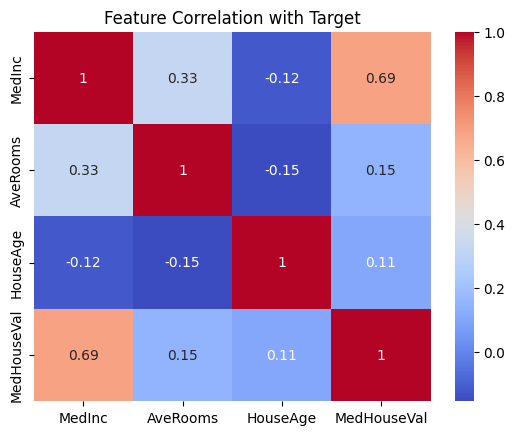

In [184]:
correlation = data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Target")
plt.show()

In [185]:
# Prepare data
X = data[['MedInc', 'AveRooms' ,'HouseAge']]

# Rename 'MedHouseVal' to 'Target' and extract it as the target variable
data = data.rename(columns={'MedHouseVal': 'Target'})
y = data['Target']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_features = X_train.columns.tolist()
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print(y_train.head())

Training samples: 16512, Testing samples: 4128
14196    1.030
8267     3.821
17445    1.726
14265    0.934
2271     0.965
Name: Target, dtype: float64


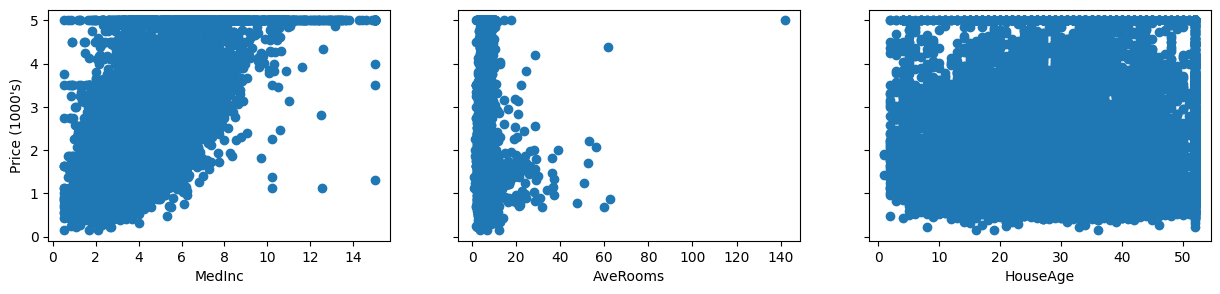

In [186]:
fig,ax=plt.subplots(1, len(X_features), figsize=(15, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train.iloc[:, i], y_train)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("Price (1000's)")
plt.show()

In [187]:
# Compute mean and standard deviation for each feature
def zscore_normalize_features(X_train, X_test):
    # Mean along columns
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0) + 1e-8  # Avoid division by zero
    X_train_scaled = (X_train - mean) / std
    # Use training set mean and std for scaling test data
    X_test_scaled = (X_test - mean) / std
    return X_train_scaled, X_test_scaled, mean, std

In [188]:
# normalize the original features
X_train_norm, X_test_norm, X_mu, X_sigma = zscore_normalize_features(X_train, X_test)
print(f"X_mu = \n {X_mu}, \nX_sigma = \n{X_sigma}")
print(f"Peak to Peak range by column in Raw X:\n {np.ptp(X_train,axis=0)}")   
print(f"Peak to Peak range by column in Normalized X:\n {np.ptp(X_train_norm,axis=0)}")

X_mu = 
 MedInc       3.880754
AveRooms     5.435235
HouseAge    28.608285
dtype: float64, 
X_sigma = 
MedInc       1.904236
AveRooms     2.387303
HouseAge    12.602118
dtype: float64
Peak to Peak range by column in Raw X:
 MedInc       14.500200
AveRooms    141.020202
HouseAge     51.000000
dtype: float64
Peak to Peak range by column in Normalized X:
 MedInc       7.614706
AveRooms    59.070937
HouseAge     4.046939
dtype: float64


In [189]:
def norm_plot(ax, data):
    scale = (np.max(data) - np.min(data))*0.2
    x = np.linspace(np.min(data)-scale,np.max(data)+scale,50)
    _ ,bins, _ = ax.hist(data, x, color="xkcd:azure")
    #ax.set_ylabel("Count")
    
    mu = np.mean(data); 
    std = np.std(data); 
    dist = norm.pdf(bins, loc = mu, scale = std)
    
    axr = ax.twinx()
    axr.plot(bins,dist, color = "orangered", lw=2)
    axr.set_ylim(bottom=0)
    axr.axis('off')

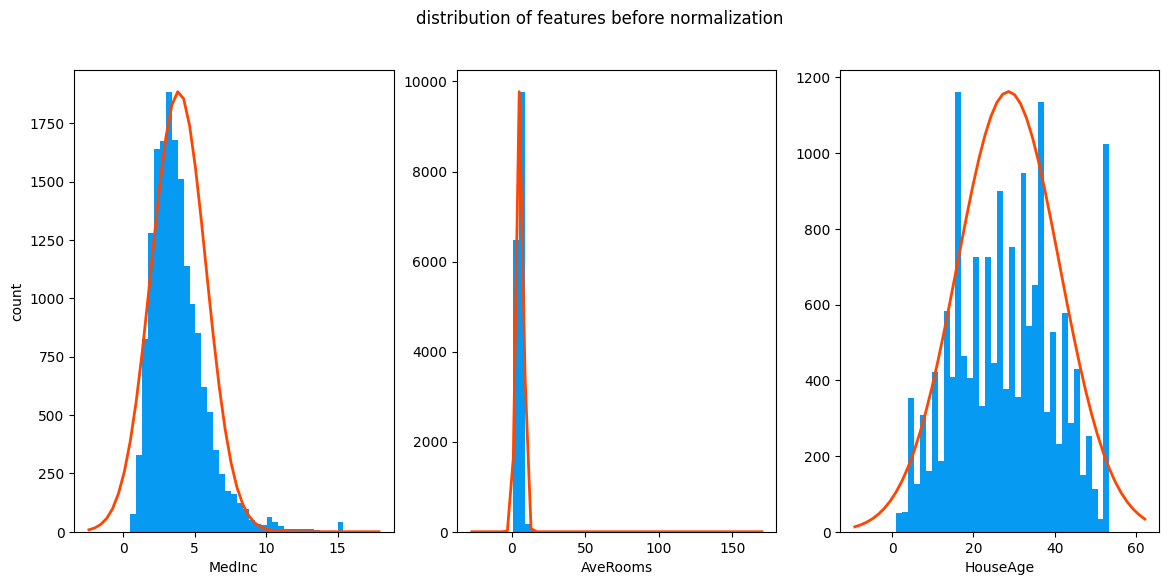

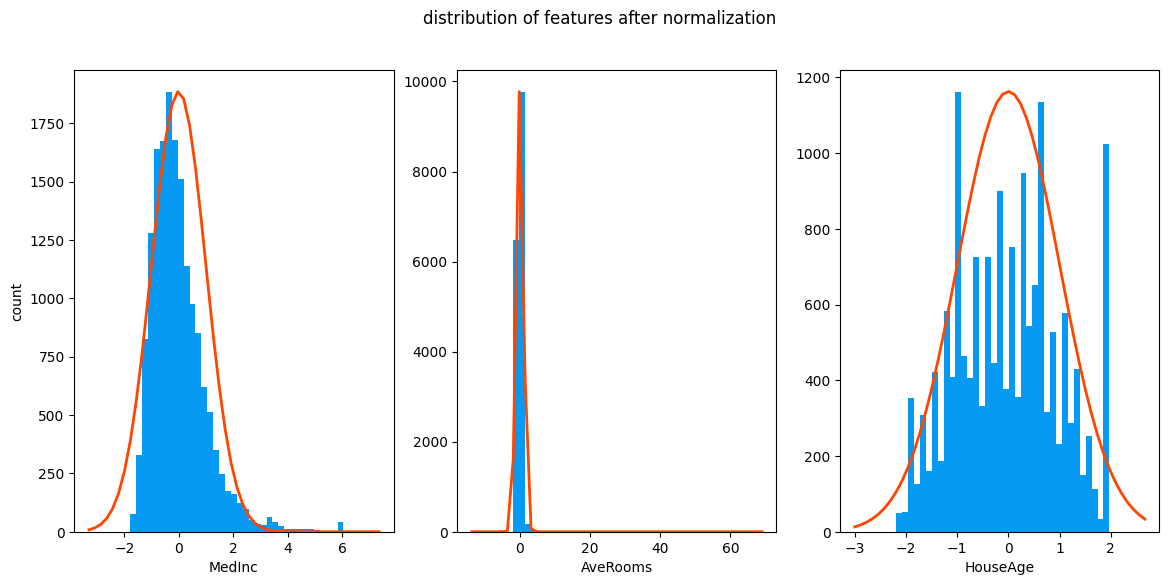

In [190]:
fig,ax = plt.subplots(1, X_train.shape[1], figsize=(14, 6))
ax = ax.flatten()
for i in range(len(ax)):
    norm_plot(ax[i], X_train.iloc[:,i],)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("count");
fig.suptitle("distribution of features before normalization")
plt.show()
fig,ax = plt.subplots(1, X_train.shape[1], figsize=(14, 6))
ax = ax.flatten()
for i in range(len(ax)):
    norm_plot(ax[i], X_train_norm.iloc[:,i],)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("count"); 
fig.suptitle("distribution of features after normalization")

plt.show()

In [191]:
def compute_cost(x, y, w, b): 
    # number of training examples
    m = x.shape[0] 
    total_cost = 0
    
    f_wb = np.dot(x, w) + b
    cost = np.sum((f_wb - y) ** 2)
    total_cost = cost / (2 * m)

    return total_cost

In [192]:
def compute_gradient(x, y, w, b): 
    # Number of training examples
    m = x.shape[0]
    dj_dw = 0
    dj_db = 0
    
    f_wb = np.dot(x, w) + b

    error = f_wb - y
    dj_dw = (1 / m) * np.dot(error, x)
    dj_db = (1 / m) * np.sum(error)
        
    return dj_dw, dj_db

In [193]:
def gradient_descent(x, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    # number of training examples
    m = len(x)
    
    # An array to store cost J and w's at each iteration — primarily for graphing later
    J_history = []
    w_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_dw, dj_db = gradient_function(x, y, w, b )  

        # Update Parameters using w, b, alpha and gradient
        w -= alpha * dj_dw               
        b -= alpha * dj_db               

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(x, y, w, b)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0:
            w_history.append(w)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w, b, J_history, w_history

In [194]:
# initialize parameters
n = X_train_norm.shape[1]
w_init = (np.random.randn(n) * 0.0001)
b_init = 0

X_train_norm = np.array(X_train_norm)
y_train = np.array(y_train)
# some gradient descent settings
epochs = 100000
alpha = 0.01

final_weights, final_bias, cost_history, weights_history = gradient_descent(X_train_norm ,y_train, w_init, b_init, 
                     compute_cost, compute_gradient, alpha, epochs)
print("w,b found by gradient descent:", final_weights, final_bias)

Iteration    0: Cost     2.77   
Iteration 10000: Cost     0.32   
Iteration 20000: Cost     0.32   
Iteration 30000: Cost     0.32   
Iteration 40000: Cost     0.32   
Iteration 50000: Cost     0.32   
Iteration 60000: Cost     0.32   
Iteration 70000: Cost     0.32   
Iteration 80000: Cost     0.32   
Iteration 90000: Cost     0.32   
w,b found by gradient descent: [ 0.84692394 -0.0672018   0.21217216] 2.071946937378854


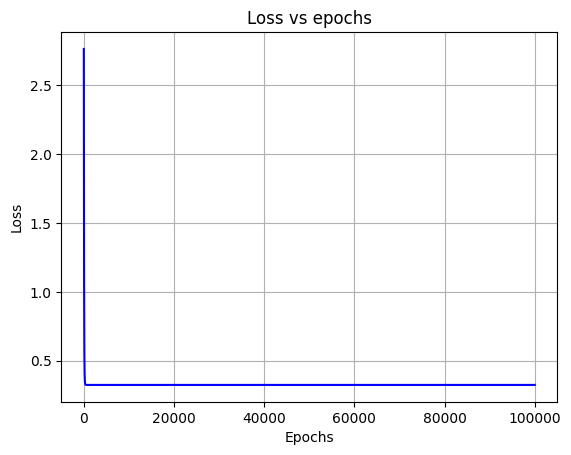

In [195]:
epochs = range(len(cost_history))
plt.plot(epochs, cost_history, c='b')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [196]:
predicted = np.dot(X_train_norm, final_weights) + final_bias

print(predicted)

[1.88137836 2.4119812  1.77425903 ... 1.81627242 2.63347091 1.94247191]


In [197]:
print("Training Predictions:")
x_train = np.array(X_train)
for x, y_actual, y_pred in zip(x_train[:5], y_train[:5], predicted[:5]):
    formatted_features = ", ".join(f"{xi:.4f}" for xi in x)
    print(f"Input: [{formatted_features}] Actual: {y_actual:.4f}, Predicted: {y_pred:.4f}")

Training Predictions:
Input: [3.2596, 5.0177, 33.0000] Actual: 1.0300, Predicted: 1.8814
Input: [3.8125, 4.4735, 49.0000] Actual: 3.8210, Predicted: 2.4120
Input: [4.1563, 5.6458, 4.0000] Actual: 1.7260, Predicted: 1.7743
Input: [1.9425, 4.0028, 36.0000] Actual: 0.9340, Predicted: 1.3747
Input: [3.5542, 6.2684, 43.0000] Actual: 0.9650, Predicted: 2.1456


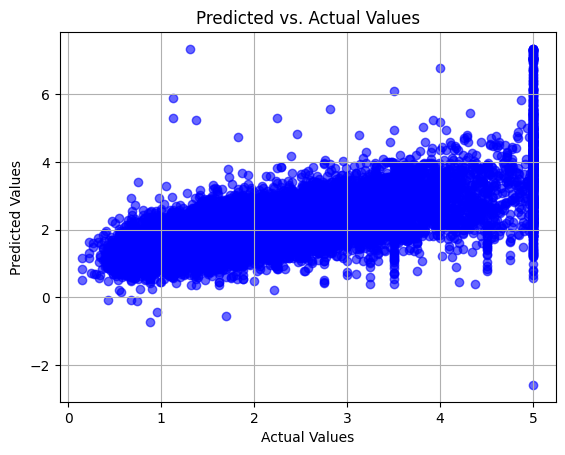

In [198]:
plt.scatter(y_train, predicted, c='blue', alpha=0.6)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Values")
plt.grid(True)
plt.show()

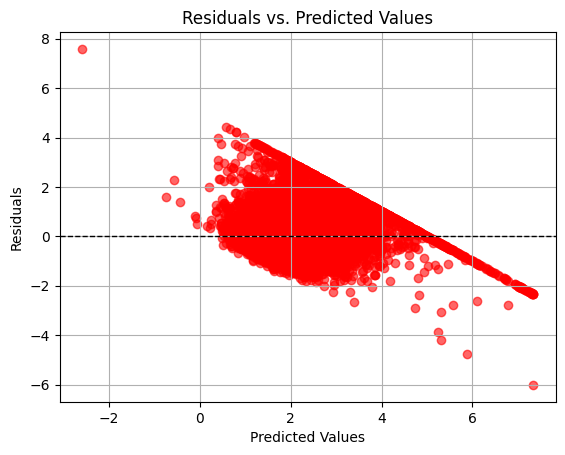

In [199]:
residuals = y_train - predicted
plt.scatter(predicted, residuals, c='red', alpha=0.6)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.grid(True)
plt.show()

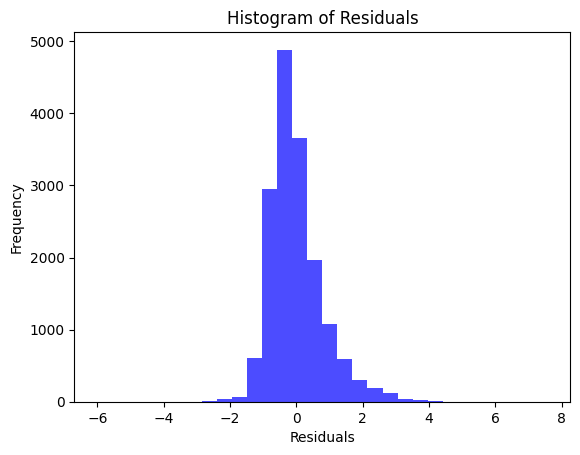

In [200]:
plt.hist(residuals, bins=30, color='blue', alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

In [201]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute metrics
mse = mean_squared_error(y_train, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, predicted)
r2 = r2_score(y_train, predicted)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-Squared (R^2): {r2:.4f}")

Mean Squared Error (MSE): 0.6474
Root Mean Squared Error (RMSE): 0.8046
Mean Absolute Error (MAE): 0.5987
R-Squared (R^2): 0.5157


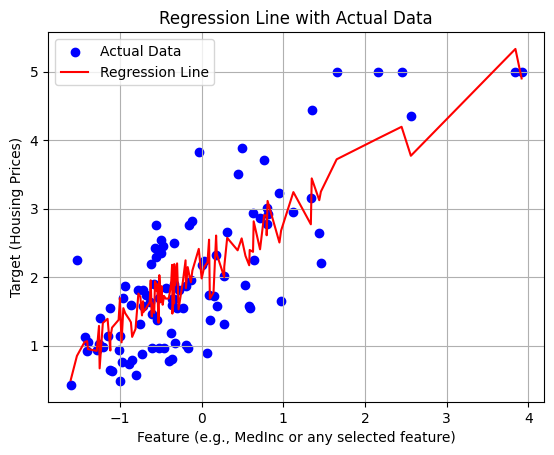

In [202]:
# Assuming these are your training samples
X_train_sample = X_train_norm[:100]  # Use a subset for visualization if the dataset is large
y_train_sample = y_train[:100]  # Corresponding actual values
predicted_sample = predicted[:100]  # Predicted values

# Sort the data for a clean regression line
sorted_indices = np.argsort(X_train_sample[:, 0])  # Sorting based on the first feature
X_sorted = X_train_sample[sorted_indices]
y_sorted_pred = np.array(predicted_sample)[sorted_indices]

# Plot actual data
plt.scatter(X_train_sample[:, 0], y_train_sample, color='blue', label="Actual Data")

# Plot the regression line
plt.plot(X_sorted[:, 0], y_sorted_pred, color='red', label="Regression Line")

# Add labels and title
plt.title("Regression Line with Actual Data")
plt.xlabel("Feature (e.g., MedInc or any selected feature)")
plt.ylabel("Target (Housing Prices)")
plt.legend()
plt.grid()

# Show the plot
plt.show()